In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

df = pd.read_csv("/Users/thunthita/Lidarforiypnb/LIDar/csvfiles/05-01-2026/00.05.csv")
AfterPulse = pd.read_csv("/Users/thunthita/Lidarforiypnb/LIDar/RawFile/AfterPulse.csv")
AfterPulse

,range_m,afterpulse_counts_per_bin,afterpulse_raw
0,0.00,0.0,0.0
1,3.75,0.0,0.0
2,7.50,0.0,0.0
3,11.25,0.0,0.0
4,15.00,0.0,0.0
...,...,...,...
4495,16856.25,NaN,NaN
4496,16860.00,NaN,NaN
4497,16863.75,NaN,NaN
4498,16867.50,NaN,NaN


In [2]:
#parameter

#note: blend region shold be wider than overlap about 50 unit to make a smooth line
config = {
    "bin_width_ns": 25,
    "bin_spacing_m": 3.75,
    "prf_hz": 20,
    "dead_time_ns": 3.06,
    "bg_start_m": 3000,
    "bg_end_m": 5621.25,
    "overlap_r1_m": 200,
    "overlap_r2_m": 300,
    "shift_search_bins": 20,
    "afterpulse_provided": True,
    "k_scale": 0.064021849,
    "b_offset": 0,
}


In [3]:
# add bin no. and bin_spacing 
bin_spacing_m = 3.75
range_m = 2000

# add bin_index (0, 1, 2, ...)
df.insert(0, "bin_index", np.arange(len(df)))

# add range_m (0, 3.75, 7.5, ...)
df.insert(1, "range_m", df["bin_index"] * bin_spacing_m)

#find signal to noise ratio
df["SNR_analog"] = df["analog"] / df["analog_sterr"]
df["SNR_Photon"] = df["photon_counting"] / df["pc_sterr"]

#Change MHz to Photon_per_bin
df["photon_per_bin"] = df["photon_counting"] * config["bin_width_ns"] * 1e-3

print(df.head())

   bin_index  range_m    analog  analog_sterr  photon_counting  pc_sterr  \
0          0     0.00   28.9665      0.166826         176.1600  0.899132   
1          1     3.75   67.2555      0.400356         195.0520  0.864446   
2          2     7.50  274.8830      2.351700         114.0360  1.378620   
3          3    11.25  473.2520      0.070407           1.2828  0.143848   
4          4    15.00  473.4570      0.000000           0.0000  0.000000   

   overflow_info   SNR_analog  SNR_Photon  photon_per_bin  
0            0.0   173.633007  195.922289         4.40400  
1            0.0   167.989240  225.638154         4.87630  
2            0.0   116.886933   82.717500         2.85090  
3            0.0  6721.670745    8.917747         0.03207  
4            0.0          inf         NaN         0.00000  


In [4]:
#Need to cut data from 1500+
#df_0_1500 is data from 0-1500
df_0_1500 = df[(df["range_m"] >= 0) & (df["range_m"] <= 1500)]
#AfterPulse = AfterPulse[(AfterPulse["range_m"] >= 0) & (AfterPulse["range_m"] <= 1500)]

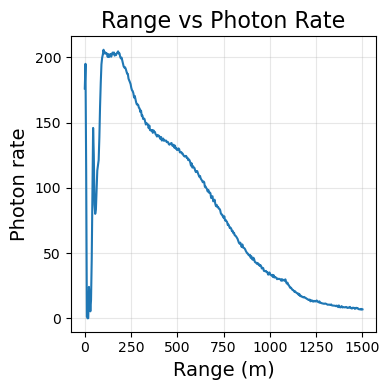

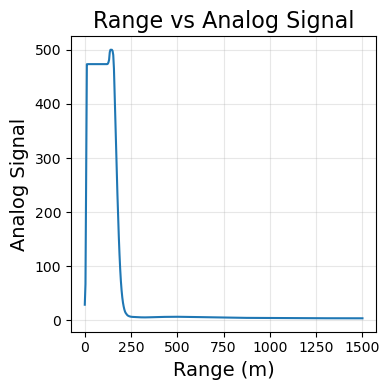

In [5]:
def plot_xy(
    df,
    xcol,
    ycol,
    *,
    title=None,
    xlabel=None,
    ylabel=None,
    xscale="linear",
    yscale="linear",
    figsize=(4, 4),
    outfile=None,
    dpi=300,
):
    # auto labels if not provided
    if title is None:
        title = f"{ycol} vs {xcol}"
    if xlabel is None:
        xlabel = xcol
    if ylabel is None:
        ylabel = ycol

    plt.figure(figsize=figsize)
    plt.plot(df[xcol], df[ycol])

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)

    plt.xscale(xscale)
    plt.yscale(yscale)

    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()

    if outfile is not None:
        plt.savefig(outfile, dpi=dpi)

    plt.show()

#plot PhotonRate vs Range
plot_xy(
    df_0_1500,
    xcol="range_m",
    ycol="photon_counting",
    yscale="linear",
    title="Range vs Photon Rate",
    xlabel="Range (m)",
    ylabel="Photon rate",
    outfile="RawFilePicforExample/Prototype/range_vs_photon_rate.png",
)
#plot PhotonRate vs Range
plot_xy(
    df_0_1500,
    xcol="range_m",
    ycol="analog",
    yscale="linear",
    title="Range vs Analog Signal",
    xlabel="Range (m)",
    ylabel="Analog Signal",
    outfile="RawFilePicforExample/Prototype/range_vs_Analog_Signal.png",
)

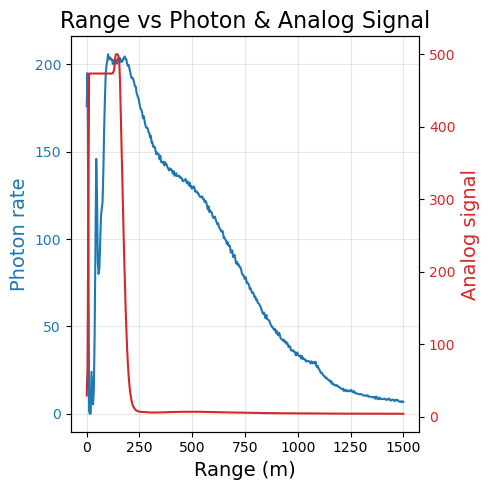

In [6]:
fig, ax1 = plt.subplots(figsize=(5,5))

# Left y-axis (Photon)
ax1.plot(df_0_1500["range_m"], df_0_1500["photon_counting"], color="tab:blue", label="Photon rate")
ax1.set_xlabel("Range (m)", fontsize=14)
ax1.set_ylabel("Photon rate", color="tab:blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)

# Right y-axis (Analog)
ax2 = ax1.twinx()
ax2.plot(df_0_1500["range_m"], df_0_1500["analog"], color="tab:red", label="Analog signal")
ax2.set_ylabel("Analog signal", color="tab:red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Range vs Photon & Analog Signal", fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
#Find Background for Photon per Bin Rate and Analog Signal
bg_row = df[(df["range_m"] >= config["bg_start_m"]) & (df["range_m"] <= config["bg_end_m"])]

Analog_bg_mean = bg_row["analog"].mean()
Photon_bg_mean = bg_row["photon_per_bin"].mean()

#Show Background value
print("Analog background (mean):", Analog_bg_mean)
print("Photon Per Bin background (mean):", Photon_bg_mean)

Analog background (mean): 3.717622357142857
Photon Per Bin background (mean): 0.0064711142571428565


In [8]:
df["analog_bg_corr"] = df["analog"] - Analog_bg_mean
df["Photon_per_bin_bg_corr"] = df["photon_per_bin"] - Photon_bg_mean

In [9]:
df["afterpulse_raw"] = AfterPulse["afterpulse_raw"]
df["afterpulse_counts_per_bin"] = df["afterpulse_raw"] * config["bin_width_ns"] * 1e-3

In [10]:
df["photon_APcorr_counts"] = df["Photon_per_bin_bg_corr"]-df["afterpulse_counts_per_bin"]
bin_width_s = config["bin_width_ns"] * 1e-9
dead_time_s = config["dead_time_ns"] * 1e-9

df["photon_deadtime_counts"] = (
    df["photon_APcorr_counts"]
    / (1 - df["photon_APcorr_counts"] * dead_time_s / bin_width_s)
)

#It will invalid in this case
ratio = df["photon_deadtime_counts"] * dead_time_s / bin_width_s

df["photon_deadtime_corr"] = np.where(
    ratio < 1,
    df["photon_deadtime_counts"] / (1 - ratio),
    np.nan   # invalid / saturated
)

In [11]:
df

,bin_index,range_m,analog,analog_sterr,photon_counting,pc_sterr,overflow_info,SNR_analog,SNR_Photon,photon_per_bin,analog_bg_corr,Photon_per_bin_bg_corr,afterpulse_raw,afterpulse_counts_per_bin,photon_APcorr_counts,photon_deadtime_counts,photon_deadtime_corr
0,0,0.00,28.9665,0.166826,176.1600,0.899132,0.0,173.633007,195.922289,4.40400,25.248878,4.397529,0.0,0.0,4.397529,9.523770,NaN
1,1,3.75,67.2555,0.400356,195.0520,0.864446,0.0,167.989240,225.638154,4.87630,63.537878,4.869829,0.0,0.0,4.869829,12.056033,NaN
2,2,7.50,274.8830,2.351700,114.0360,1.378620,0.0,116.886933,82.717500,2.85090,271.165378,2.844429,0.0,0.0,2.844429,4.363679,9.366416
3,3,11.25,473.2520,0.070407,1.2828,0.143848,0.0,6721.670745,8.917747,0.03207,469.534378,0.025599,0.0,0.0,0.025599,0.025679,0.025760
4,4,15.00,473.4570,0.000000,0.0000,0.000000,0.0,inf,NaN,0.00000,469.739378,-0.006471,0.0,0.0,-0.006471,-0.006466,-0.006461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,7481.25,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,-3.717622,-0.006471,NaN,NaN,NaN,NaN,NaN
1996,1996,7485.00,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,-3.717622,-0.006471,NaN,NaN,NaN,NaN,NaN
1997,1997,7488.75,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,-3.717622,-0.006471,NaN,NaN,NaN,NaN,NaN
1998,1998,7492.50,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,-3.717622,-0.006471,NaN,NaN,NaN,NaN,NaN


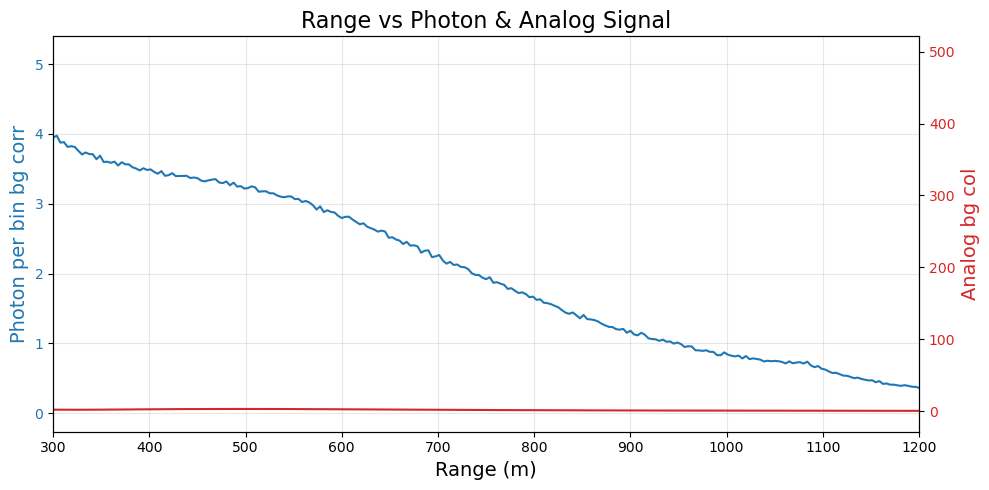

In [12]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis (Photon)
ax1.plot(df["range_m"], df["Photon_per_bin_bg_corr"], color="tab:blue", label="Photon rate")
ax1.set_xlabel("Range (m)", fontsize=14)
ax1.set_ylabel("Photon per bin bg corr", color="tab:blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)

# Right y-axis (Analog)
ax2 = ax1.twinx()
ax2.plot(df["range_m"], df["analog_bg_corr"], color="tab:red", label="Analog signal")
ax2.set_ylabel("Analog bg col", color="tab:red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="tab:red")

# ZOOM HERE
ax1.set_xlim(300, 1200)   # try 0–2000 m first

plt.title("Range vs Photon & Analog Signal", fontsize=16)
plt.tight_layout()
plt.show()


In [13]:
m_overlap = df[(df["range_m"] >= config["overlap_r1_m"]) & (df["range_m"] <= config["overlap_r2_m"])]

x = m_overlap["analog_bg_corr"].to_numpy()
y = m_overlap["Photon_per_bin_bg_corr"].to_numpy()

k_scale, b_offset, r, *_ = linregress(x, y)

print("k_scale =", k_scale,
      "b_offset =", b_offset,
      "R^2 =", r**2)

df["analog_scaled_for_glue"] = k_scale * df["analog_bg_corr"] + b_offset

k_scale = 0.024337560957663856 b_offset = 4.256087142709171 R^2 = 0.5350315012138119


In [14]:
blend_r1_m = config["overlap_r1_m"] - 100   # or -50
blend_r2_m = config["overlap_r2_m"] + 100   # or +50

r = df["range_m"].to_numpy()

w = np.zeros_like(r, dtype=float)

# r > r2  -> w = 1
w[r > blend_r2_m] = 1.0

# r1 <= r <= r2 -> cosine blend
m = (r >= blend_r1_m) & (r <= blend_r2_m)
w[m] = 0.5 * (1.0 - np.cos(np.pi * (r[m] - blend_r1_m) / (blend_r2_m - blend_r1_m)))

df["weight_w"] = w

In [15]:
df["merged_counts_per_bin"] = (
    (1.0 - df["weight_w"]) * df["analog_scaled_for_glue"]
    + df["weight_w"] * df["Photon_per_bin_bg_corr"]
)
df["range2_corrected_counts"] = (
    df["merged_counts_per_bin"] * df["range_m"]**2
)
df["range2_norm"] = (
    df["range2_corrected_counts"] /
    df["range2_corrected_counts"].max()
)


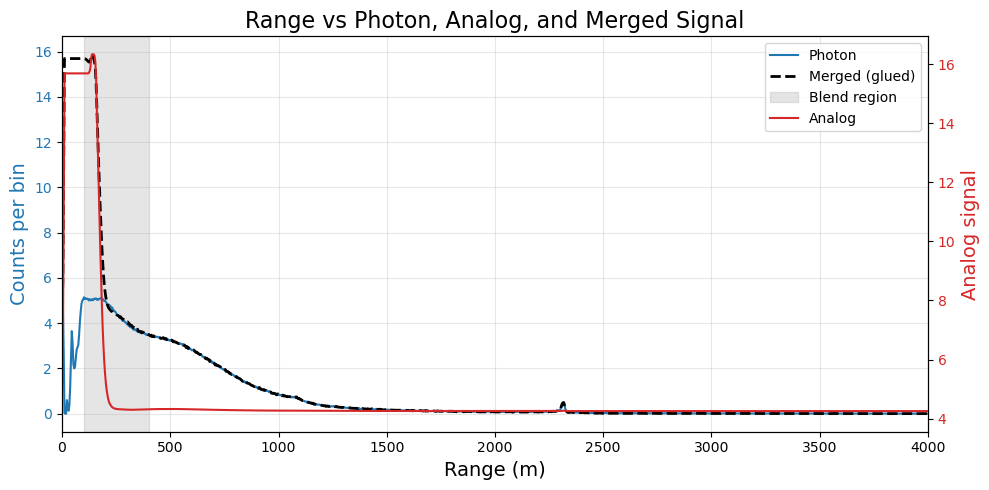

In [16]:
fig, ax1 = plt.subplots(figsize=(10,5))

# --- Left y-axis: Photon + Merged ---
ax1.plot(
    df["range_m"],
    df["Photon_per_bin_bg_corr"],
    color="tab:blue",
    label="Photon"
)

ax1.plot(
    df["range_m"],
    df["merged_counts_per_bin"],
    color="black",
    linestyle="--",
    linewidth=2,
    label="Merged (glued)"
)

ax1.set_xlabel("Range (m)", fontsize=14)
ax1.set_ylabel("Counts per bin", color="tab:blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)

# --- Right y-axis: Analog ---
ax2 = ax1.twinx()
ax2.plot(
    df["range_m"],
    df["analog_scaled_for_glue"],
    color="tab:red",
    label="Analog"
)
ax1.axvspan(
    blend_r1_m,
    blend_r2_m,
    color="gray",
    alpha=0.2,
    label="Blend region"
)
ax1.set_xlim(0, 4000) 
ax2.set_ylabel("Analog signal", color="tab:red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="tab:red")

# ax1.set_xlim(100, 1500)   # try 0–2000 m first

# --- Legend (combine both axes) ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("Range vs Photon, Analog, and Merged Signal", fontsize=16)
plt.tight_layout()
plt.show()


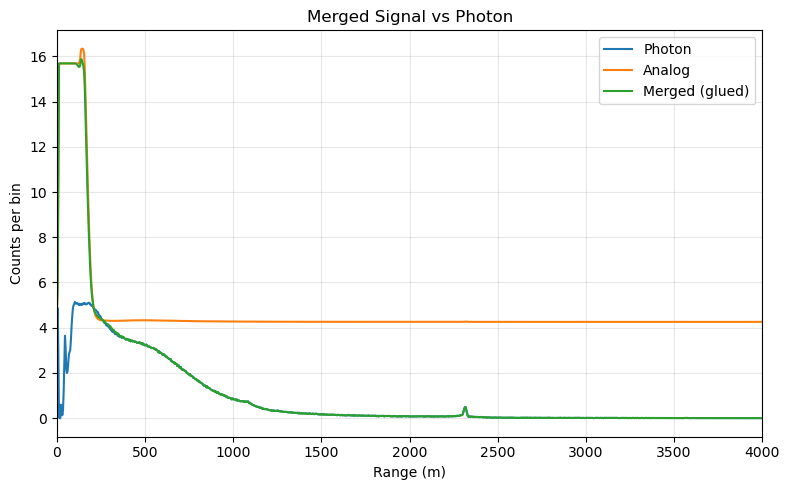

In [17]:
def plot_vs_range(
    df,
    ycols,                  # list ของ column ที่จะ plot
    *,
    xcol="range_m",
    labels=None,            # list ของ label (optional)
    title=None,
    xlabel="Range (m)",
    ylabel=None,
    yscale="linear",        # "linear" or "log"
    xlim=None,
    ylim=None,
    figsize=(8,5),
):
    plt.figure(figsize=figsize)

    if labels is None:
        labels = ycols

    for y, lab in zip(ycols, labels):
        plt.plot(df[xcol], df[y], label=lab)

    plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)

    plt.yscale(yscale)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_vs_range(
    df,
    ycols=[
        "Photon_per_bin_bg_corr",
        "analog_scaled_for_glue",
        "merged_counts_per_bin",
    ],
    labels=[
        "Photon",
        "Analog",
        "Merged (glued)",
    ],
    ylabel="Counts per bin",
    yscale="linear",
    xlim=(0, 4000),
    title="Merged Signal vs Photon",
)



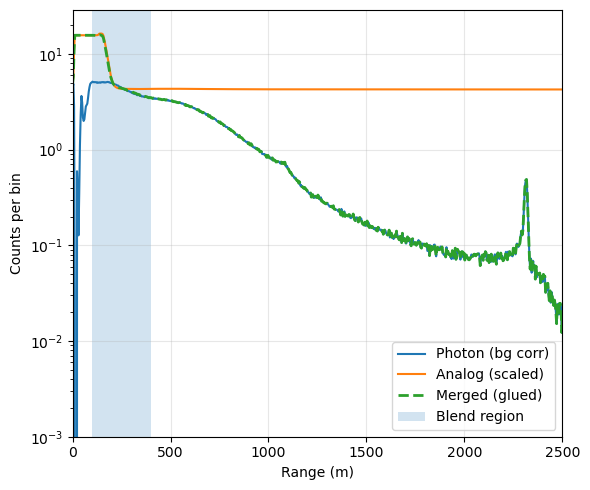

In [18]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(df["range_m"], df["Photon_per_bin_bg_corr"], label="Photon (bg corr)")
ax.plot(df["range_m"], df["analog_scaled_for_glue"], label="Analog (scaled)")
ax.plot(df["range_m"], df["merged_counts_per_bin"], "--", linewidth=2, label="Merged (glued)")

ax.axvspan(blend_r1_m, blend_r2_m, alpha=0.2, label="Blend region")
ax.set_xlabel("Range (m)")
ax.set_xlim(0, 2500) 
ax.set_ylabel("Counts per bin")
ax.set_yscale("log")
ax.set_ylim(1e-3, None)   # avoid log(0) issues
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


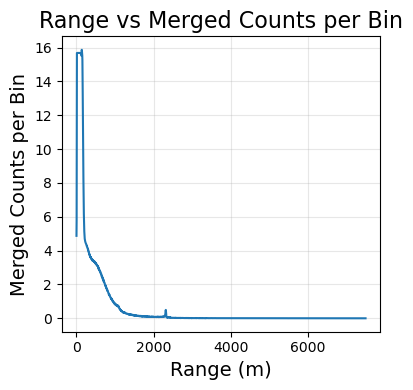

In [19]:
plot_xy(
    df,
    xcol="range_m",
    ycol="merged_counts_per_bin",
    yscale="linear",
    title="Range vs Merged Counts per Bin",
    xlabel="Range (m)",
    ylabel="Merged Counts per Bin",
    outfile="RawFilePicforExample/Prototype/range_vs_merged_counts_per_bin.png",
)

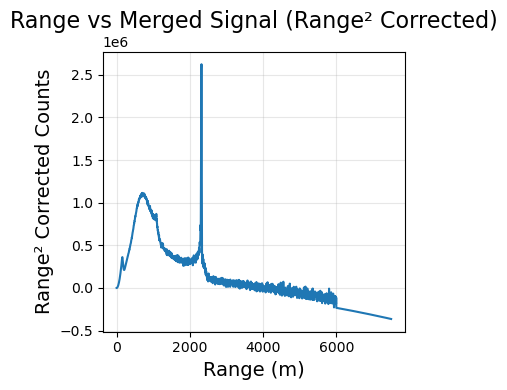

In [20]:
plot_xy(
    df,
    xcol="range_m",
    ycol="range2_corrected_counts",
    yscale="linear",
    title="Range vs Merged Signal (Range² Corrected)",
    xlabel="Range (m)",
    ylabel="Range² Corrected Counts",
    outfile="RawFilePicforExample/Prototype/range_vs_merged_counts_per_bin.png",
)

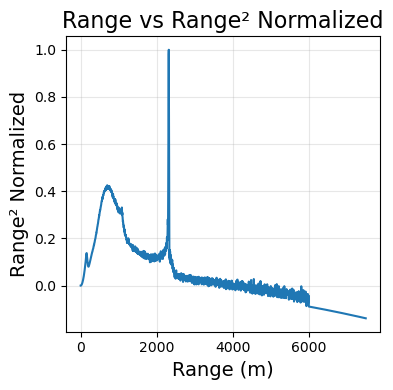

In [21]:
plot_xy(
    df,
    xcol="range_m",
    ycol="range2_norm",
    yscale="linear",
    title="Range vs Range² Normalized",
    xlabel="Range (m)",
    ylabel="Range² Normalized",
    outfile="RawFilePicforExample/Prototype/range_vs_Range2_Normalized.png",
)

In [22]:
def plot_xy_only_SNR_analog(
    df,
    xcol,
    ycol,
    *,
    title=None,
    xlabel=None,
    ylabel=None,
    xscale="linear",
    yscale="linear",
    figsize=(4, 4),
    outfile=None,
    dpi=300,
):
    # auto labels if not provided
    if title is None:
        title = f"{ycol} vs {xcol}"
    if xlabel is None:
        xlabel = xcol
    if ylabel is None:
        ylabel = ycol

    plt.figure(figsize=figsize)
    plt.plot(df[xcol], df[ycol])

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)

    plt.xscale(xscale)
    plt.yscale(yscale)

    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()

    if outfile is not None:
        plt.savefig(outfile, dpi=dpi)

    plt.show()
    plot_xy(
    df,
    xcol="range_m",
    ycol="SNR_analog",
    yscale="linear",
    title="Range vs SNR Analog",
    xlabel="Range (m)",
    ylabel="SNR Analog",
    outfile="RawFilePicforExample/Prototype/range_vs_SNR_analog.png",
)

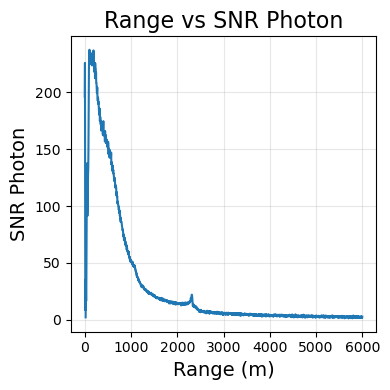

In [23]:
plot_xy(
    df,
    xcol="range_m",
    ycol="SNR_Photon",
    yscale="linear",
    title="Range vs SNR Photon",
    xlabel="Range (m)",
    ylabel="SNR Photon",
    outfile="RawFilePicforExample/Prototype/range_vs_SNR_Photon.png",
)

In [24]:
m_overlap = (
    (df["range_m"] >= config["overlap_r1_m"]) &
    (df["range_m"] <= config["overlap_r2_m"])
)

ratio = (
    df.loc[m_overlap, "analog_scaled_for_glue"] /
    df.loc[m_overlap, "photon_APcorr_counts"]
)

#On average, the scaled analog signal is (ratio mean - 1) * 100 % higher than the photon signal in the overlap region.
print("ratio mean:", ratio.mean())
#How much the ratio fluctuates from bin to bin around the mean.
print("ratio std :", ratio.std())

ratio mean: 1.0022390242508838
ratio std : 0.04768676459650233


In [25]:
df

,bin_index,range_m,analog,analog_sterr,photon_counting,pc_sterr,overflow_info,SNR_analog,SNR_Photon,photon_per_bin,...,afterpulse_raw,afterpulse_counts_per_bin,photon_APcorr_counts,photon_deadtime_counts,photon_deadtime_corr,analog_scaled_for_glue,weight_w,merged_counts_per_bin,range2_corrected_counts,range2_norm
0,0,0.00,28.9665,0.166826,176.1600,0.899132,0.0,173.633007,195.922289,4.40400,...,0.0,0.0,4.397529,9.523770,NaN,4.870583,0.0,4.870583,0.000000,0.000000
1,1,3.75,67.2555,0.400356,195.0520,0.864446,0.0,167.989240,225.638154,4.87630,...,0.0,0.0,4.869829,12.056033,NaN,5.802444,0.0,5.802444,81.596870,0.000031
2,2,7.50,274.8830,2.351700,114.0360,1.378620,0.0,116.886933,82.717500,2.85090,...,0.0,0.0,2.844429,4.363679,9.366416,10.855591,0.0,10.855591,610.626997,0.000233
3,3,11.25,473.2520,0.070407,1.2828,0.143848,0.0,6721.670745,8.917747,0.03207,...,0.0,0.0,0.025599,0.025679,0.025760,15.683409,0.0,15.683409,1984.931411,0.000757
4,4,15.00,473.4570,0.000000,0.0000,0.000000,0.0,inf,NaN,0.00000,...,0.0,0.0,-0.006471,-0.006466,-0.006461,15.688398,0.0,15.688398,3529.889523,0.001346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,7481.25,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,...,NaN,NaN,NaN,NaN,NaN,4.165609,1.0,-0.006471,-362182.451081,-0.138096
1996,1996,7485.00,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,...,NaN,NaN,NaN,NaN,NaN,4.165609,1.0,-0.006471,-362545.632257,-0.138234
1997,1997,7488.75,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,...,NaN,NaN,NaN,NaN,NaN,4.165609,1.0,-0.006471,-362908.995434,-0.138373
1998,1998,7492.50,0.0000,0.000000,0.0000,0.000000,0.0,NaN,NaN,0.00000,...,NaN,NaN,NaN,NaN,NaN,4.165609,1.0,-0.006471,-363272.540611,-0.138511


In [26]:
#MiniMPL
MiniMPL = pd.read_csv("MPL_5038_202601050005.csv")
MiniMPL["range_raw"]

0       0.029979
1       0.059958
2       0.089938
3       0.119917
4       0.149896
         ...    
995    29.859330
996    29.889309
997    29.919287
998    29.949266
999    29.979246
Name: range_raw, Length: 1000, dtype: float64

In [27]:
# Select + rename columns
MiniMPL_for_process = pd.DataFrame({
    "range_raw": MiniMPL["range_raw"],
    "range (m) for NRB": MiniMPL["range_raw"]*1000,
    "range (m)": MiniMPL["range_nrb"]*1000,
    "copol_raw": MiniMPL["copol_raw"],
    "copol_snr": MiniMPL["copol_snr"],
    "copol_nrb": MiniMPL["copol_nrb"],
    "pbls": MiniMPL["pbls"],
    "Normalize copol nrb": MiniMPL["copol_nrb"]/MiniMPL["copol_nrb"].max(),
})

# Save to CSV
MiniMPL_for_process.to_csv("MiniMPL_for_process_202601050005.csv", index=False)

In [28]:
MiniMPL_for_process = pd.read_csv("MiniMPL_for_process_202601050005.csv")
MiniMPL_for_process

,range_raw,range (m) for NRB,range (m),copol_raw,copol_snr,copol_nrb,pbls,Normalize copol nrb
0,0.029979,29.979246,119.91698,23.136173,77188.660000,0.210972,2.038589,0.436949
1,0.059958,59.958490,149.89623,9.782225,32632.969000,0.222797,NaN,0.461439
2,0.089938,89.937740,179.87548,8.616079,28744.936000,0.230906,NaN,0.478235
3,0.119917,119.916980,209.85472,8.102901,27033.842000,0.225396,NaN,0.466823
4,0.149896,149.896230,239.83397,8.185528,27307.549000,0.199954,NaN,0.414130
...,...,...,...,...,...,...,...,...
995,29.859330,29859.330000,NaN,0.000684,-0.016672,NaN,NaN,NaN
996,29.889309,29889.309000,NaN,0.000640,-0.156336,NaN,NaN,NaN
997,29.919287,29919.287000,NaN,0.000625,-0.206875,NaN,NaN,NaN
998,29.949266,29949.266000,NaN,0.000535,-0.500491,NaN,NaN,NaN


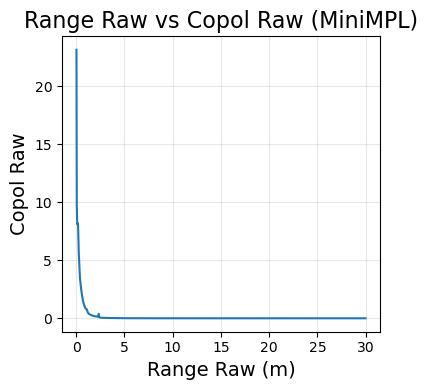

In [29]:
plot_xy(
    MiniMPL_for_process,
    xcol="range_raw",
    ycol="copol_raw",
    yscale="linear",
    title="Range Raw vs Copol Raw (MiniMPL)",
    xlabel="Range Raw (m)",
    ylabel="Copol Raw",
    outfile="RawFilePicforExample/MiniMPL/Range_Raw_vs_Copol_Raw(MiniMPL).png",
)

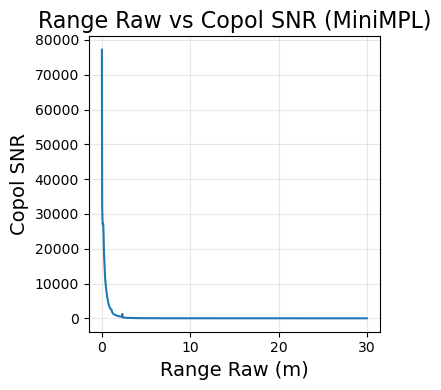

In [30]:
plot_xy(
    MiniMPL_for_process,
    xcol="range_raw",
    ycol="copol_snr",
    yscale="linear",
    title="Range Raw vs Copol SNR (MiniMPL)",
    xlabel="Range Raw (m)",
    ylabel="Copol SNR",
    outfile="RawFilePicforExample/MiniMPL/Range_Raw_vs_Copol_SNR(MiniMPL).png",
)

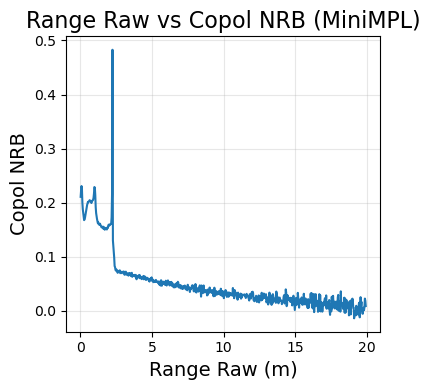

In [31]:
plot_xy(
    MiniMPL_for_process,
    xcol="range_raw",
    ycol="copol_nrb",
    yscale="linear",
    title="Range Raw vs Copol NRB (MiniMPL)",
    xlabel="Range Raw (m)",
    ylabel="Copol NRB",
    outfile="RawFilePicforExample/MiniMPL/Range_Raw_vs_Copol_NRB(MiniMPL).png",
)

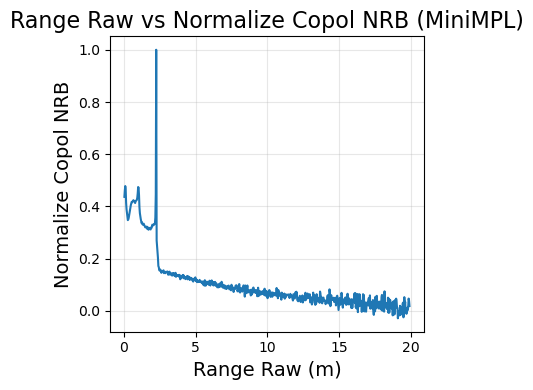

In [32]:
plot_xy(
    MiniMPL_for_process,
    xcol="range_raw",
    ycol="Normalize copol nrb",
    yscale="linear",
    title="Range Raw vs Normalize Copol NRB (MiniMPL)",
    xlabel="Range Raw (m)",
    ylabel="Normalize Copol NRB",
    outfile="RawFilePicforExample/MiniMPL/Range_Raw_vs_Normalize_copol_nrb(MiniMPL).png",
)

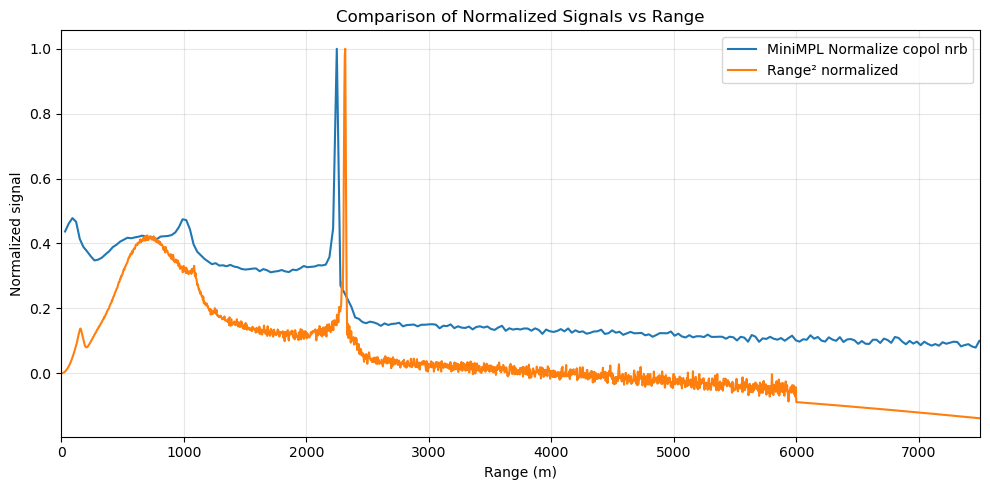

In [33]:
plt.figure(figsize=(10, 5))

plt.plot(
    MiniMPL_for_process["range (m) for NRB"],
    MiniMPL_for_process["Normalize copol nrb"],
    label="MiniMPL Normalize copol nrb",
)

plt.plot(
    df["range_m"],
    df["range2_norm"],
    label="Range² normalized",
)
plt.xlim(0, 7500)   # example: 0–8 km
plt.xlabel("Range (m)")
plt.ylabel("Normalized signal")
plt.title("Comparison of Normalized Signals vs Range")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()